# Demo of Perfect Model Predictability Functions

This demo demonstrates `climpred`'s capabilities for a perfect-model framework ensemble simulation.

**What's a perfect-model framework simulation?**

A perfect-model framework uses a set of ensemble simulations that are based on a General Circulation Model (GCM) or Earth System Model (ESM) alone. There is *no* use of any reanalysis, reconstruction, or data product to initialize the decadal prediction ensemble. An arbitrary number of `members` are initialized from perturbed initial conditions, and the control simulation can be viewed as just another member, in `climpred`'s view as member 0.


**How to compare predictability skill score:**
As no observational data interferes with the random climate evolution of the model, we cannot use an observation-based reference for computing skill scores. Therefore, we can compare the members with one another (`m2m`), against the ensemble mean (`m2e`), or against the control (`m2c`). We can also compare the ensemble mean to the control member (`e2c`). See the [comparisons](https://climpred.readthedocs.io/en/latest/comparisons.html) page for more information.

**When to use perfect-model frameworks:**

- You don't have a sufficiently long observational record to use as a reference.
- You want to avoid biases between model climatology and reanalysis climatology.
- You want to avoid sensitive reactions of biogeochemical cycles to disruptive changes in ocean physics due to assimilation.
- You want to delve into process understanding of predictability in a model without outside artifacts.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import climpred

**Load sample data**

Here we use a subset of ensembles and members from the MPI-ESM-LR (CMIP6 version) esmControl simulation of an early state.

## 1-dimensional output

Our 1D sample output contains datasets of time series of certain spatially averaged `area` (`'global'`, `'North_Atlantic'`) and temporally averaged `period` ('ym', 'DJF', ...) for some `lead` years (1, ..., 20).

`ds`: The ensemble dataset of all `member`s (1, ..., 10), `init`s (initialization years: 3014, 3023, ..., 3257), `area`s, `period`s, and `lead` years.

`control`: The control dataset with the same areas and periods, as well as the years 3000 to 3299.

In [2]:
ds = climpred.tutorial.load_dataset('MPI-PM-DP-1D').isel(area=1, period=-1)
control = climpred.tutorial.load_dataset('MPI-control-1D').isel(area=1, period=-1)

ds['lead'].attrs = {'units': 'years'}

We'll sub-select annual means (`'ym'`) of sea surface temperature (`'tos'`) in the North Atlantic.

In [3]:
# Add to climpred PerfectModelEnsemble object.
pm = climpred.PerfectModelEnsemble(ds)
pm = pm.add_control(control)
pm

/Users/aaron.spring/Coding/climpred/climpred/utils.py:140: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


climpred.PerfectModelEnsemble

<Initialized Ensemble>
Dimensions: (init: 12, lead: 20, member: 10)
Coordinates:
 * lead (lead) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
 period <U2 'ym'
 area <U14 'North_Atlantic'
 * init (init) object 3014-01-01 00:00:00 ... 3257-01-01 00:00:00
 * member (member) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
 tos (lead, init, member) float32 10.78 10.92 11.11 ... 10.83 10.89
 sos (lead, init, member) float32 33.38 33.37 33.28 ... 33.5 33.4 33.48
 AMO (lead, init, member) float32 0.07232 0.1894 ... -0.01757 0.06075 Initialized Ensemble Dimensions: init : 12 lead : 20 member : 10 Coordinates: (5) lead (lead) int64 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 units : years array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
 19, 20]) period () <U2 'ym' array('ym', dtype='<U2') area () <U14 'North_Atlantic' array('North_Atlantic', dtype='<U14') init (init) object 3014-01-01 00:00:00 ... 3257-01-... array([cftime.DatetimeProlepticGregorian(3014, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3023, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3045, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3061, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3124, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3139, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3144, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3175, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3178, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3228, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3237, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3257, 1, 1, 0, 0, 0, 0)], dtype=object) member (member) int64 0 1 2 3 4 5 6 7 8 9 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) Data variables: (3) tos (lead, init, member) float32 ... array([[[10.781249, 10.917702, ..., 10.897053, 10.843189],
 [10.727219, 10.813577, ..., 10.803096, 10.651206],
 ...,
 [10.294819, 10.539777, ..., 10.442225, 10.412181],
 [10.385962, 10.594727, ..., 10.409877, 10.403644]],

 [[11.026904, 10.881209, ..., 10.903457, 10.85706 ],
 [10.936329, 11.062461, ..., 10.968625, 11.082683],
 ...,
 [10.113186, 10.293538, ..., 10.450742, 10.182688],
 [10.549644, 10.482872, ..., 10.614776, 10.51542 ]],

 ...,

 [[10.877393, 10.962437, ..., 10.858264, 10.441303],
 [10.503685, 10.489896, ..., 11.052794, 10.790496],
 ...,
 [10.694736, 10.678864, ..., 10.324147, 10.555562],
 [10.533122, 10.690272, ..., 10.522203, 11.049645]],

 [[11.197919, 10.93896 , ..., 10.838304, 10.451338],
 [10.67775 , 10.550334, ..., 10.607387, 10.692555],
 ...,
 [10.642373, 10.502099, ..., 10.11778 , 10.391133],
 [10.826764, 10.684681, ..., 10.829444, 10.894786]]], dtype=float32) sos (lead, init, member) float32 ... array([[[33.379833, 33.366467, ..., 33.36124 , 33.32225 ],
 [33.377155, 33.373028, ..., 33.346344, 33.38318 ],
 ...,
 [33.217045, 33.2169 , ..., 33.24268 , 33.241886],
 [33.27586 , 33.298878, ..., 33.232338, 33.308716]],

 [[33.408016, 33.325253, ..., 33.42898 , 33.345768],
 [33.3932 , 33.400852, ..., 33.3288 , 33.398758],
 ...,
 [33.277046, 33.27699 , ..., 33.328503, 33.218845],
 [33.33428 , 33.243446, ..., 33.216988, 33.290936]],

 ...,

 [[33.39525 , 33.51696 , ..., 33.341 , 33.238438],
 [33.367573, 33.445225, ..., 33.315975, 33.344593],
 ...,
 [33.387165, 33.345234, ..., 33.189358, 33.299137],
 [33.420033, 33.389782, ..., 33.43263 , 33.552074]],

 [[33.36968 , 33.55584 , ..., 33.390663, 33.31099 ],
 [33.402542, 33.388348, ..., 33.343822, 33.431545],
 ...,
 [33.246838, 33.30958 , ..., 33.144096, 33.204456],
 [33.4219 , 33.406277, ..., 33.40383 , 33.48065 ]]], dtype=float32) AMO (lead, init, member) float32 ... array([[[ 0.072317, 0.189433, ..., 0.183764, 0.139705],
 [-0.05801 , -0.092494, ..., 0.131268, -0.141136],
 ...,
 [-0.250911, -0.144247, ..., -0.144506, -0.102277],
 [-0.208696, -0.057604, ..., -0.150325, -0.327045]],

 [[ 0.222662, 0.05584 , ..., 0.081747, -0.005777],
 [ 0.085213, -0.02169 , ..., 0.237478, 0.120696],
 ...,
 [-

<Control Simulation>
Dimensions: (time: 300)
Coordinates:
 * time (time) object 3000-01-01 00:00:00 ... 3299-01-01 00:00:00
 period <U2 'ym'
 area <U14 'North_Atlantic'
Data variables:
 tos (time) float32 10.91 10.96 10.93 11.12 ... 10.54 10.52 10.59 10.84
 sos (time) float32 33.45 33.37 33.42 33.44 ... 33.4 33.46 33.39 33.38
 AMO (time) float32 0.1678 0.1614 -0.1101 ... 0.01479 -0.02503 0.07905 Control Simulation Dimensions: time : 300 Coordinates: (3) time (time) object 3000-01-01 00:00:00 ... 3299-01-... array([cftime.DatetimeProlepticGregorian(3000, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3001, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3002, 1, 1, 0, 0, 0, 0), ...,
 cftime.DatetimeProlepticGregorian(3297, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3298, 1, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(3299, 1, 1, 0, 0, 0, 0)], dtype=object) period () <U2 'ym' array('ym', dtype='<U2') area () <U14 'North_Atlantic' array('North_Atlantic', dtype='<U14') Data variables: (3) tos (time) float32 ... array([10.906495, 10.958404, 10.93251 , ..., 10.516892, 10.586926, 10.836343],
 dtype=float32) sos (time) float32 ... array([33.449768, 33.3701 , 33.424828, ..., 33.455902, 33.391457, 33.38208 ],
 dtype=float32) AMO (time) float32 ... array([ 0.167775, 0.161447, -0.110121, ..., 0.01479 , -0.02503 , 0.079047],
 dtype=float32) Attributes: (0)

`PredictionEnsemble.plot()` displays ensemble timeseries for 1-dimensional data.

<AxesSubplot:title={'center':' '}, xlabel='time', ylabel='tos'>

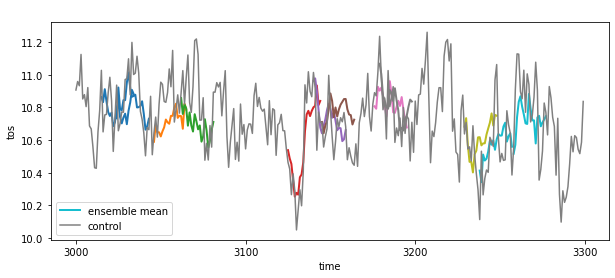

In [4]:
pm.plot()

### Verification

Optionally, `PredictionEnsemble.verify(reference=...)` verifies against reference forecasts (like persistence or historical).

In [5]:
pm = pm.generate_uninitialized()

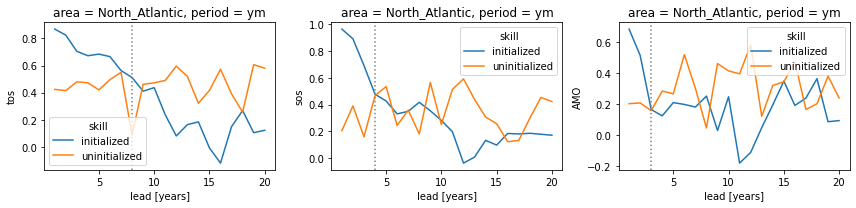

In [6]:
from climpred.horizon import horizon

skill = pm.verify(metric='acc', comparison='m2e', dim=['init', 'member'], reference=['uninitialized'])
ph = horizon(skill.sel(skill='initialized') > skill.sel(skill='uninitialized'))
fig, ax = plt.subplots(ncols=3, figsize=(12,3))
for i,v in enumerate(skill.data_vars):
    fg = skill[v].plot(hue='skill',ax=ax[i])
    # adds gray line at last lead where initialized > uninitialized
    ax[i].axvline(x=ph[v], c='gray', ls=':', label='predictability horizon')
plt.tight_layout()

### Bootstrapping with Replacement

Here, we bootstrap the ensemble with replacement [Goddard et al. 2013] to compare the initialized ensemble to an "uninitialized" counterpart and a persistence forecast. The visualization is based on those used in [Li et al. 2016]. The p-value demonstrates the probability that the uninitialized or persistence beats the initialized forecast based on N bootstrapping with replacement.

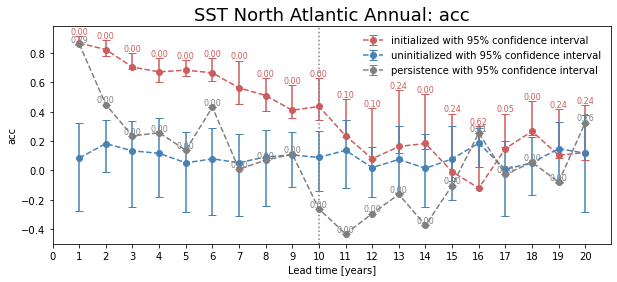

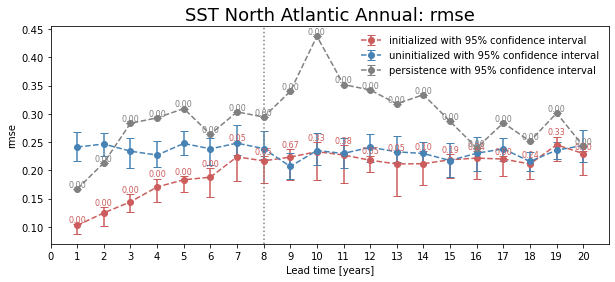

In [7]:
for metric in ['acc', 'rmse']:
    bootstrapped = pm[['tos']].bootstrap(metric=metric, comparison='m2e', dim=['init', 'member'],
                                         iterations=21, sig=95, reference=['uninitialized','persistence'])

    climpred.graphics.plot_bootstrapped_skill_over_leadyear(bootstrapped)
    # adds gray line where last lead p <= 0.05
    ph = horizon(bootstrapped.sel(results='p', skill='uninitialized') <= 0.05)
    plt.axvline(x=ph.tos, c='gray', ls=':', label='predictability horizon')
    plt.title(' '.join(['SST', 'North Atlantic', 'Annual:', metric]),fontsize=18)
    plt.ylabel(metric)
    plt.show()

### Computing Skill with Different Comparison Methods

Here, we use `compute_perfect_model` to compute the Anomaly Correlation Coefficient (ACC) with different comparison methods. This generates different ACC values by design. See the [comparisons](https://climpred.readthedocs.io/en/latest/comparisons.html) page for a description of the various ways to compute skill scores for a perfect-model framework.

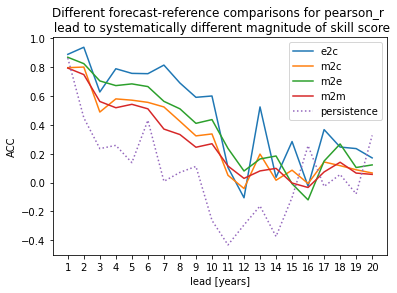

In [8]:
for c in ['e2c','m2c','m2e','m2m']:
    dim = 'init' if c == 'e2c' else ['init', 'member']
    pm.verify(metric='acc', comparison=c, dim=dim)['tos'].plot(label=c)
# Persistence computation for a baseline.
pm.verify(metric='acc', comparison=c, dim=dim, reference='persistence')['tos'].sel(skill= 'persistence').plot(label='persistence', ls=':')
plt.ylabel('ACC')
plt.xticks(np.arange(1,21))
plt.legend()
plt.title('Different forecast-reference comparisons for pearson_r \n lead to systematically different magnitude of skill score')
plt.show()

## 3-dimensional output (maps)

We also have some sample output that contains gridded time series on the curvilinear MPI grid. Our compute functions (`compute_perfect_model`, `compute_persistence`) are indifferent to any dimensions that exist in addition to `init`, `member`, and `lead`. In other words, the functions are set up to make these computations on a grid, if one includes `lat`, `lon`, `lev`, `depth`, etc.

`ds3d`: The ensemble dataset of `member`s (1, 2, 3, 4), `init`s (initialization years: 3014, 3061, 3175, 3237), and `lead` years (1, 2, 3, 4, 5).

`control3d`: The control dataset spanning (3000, ..., 3049).

**Note**: These are very small subsets of the actual MPI simulations so that we could host the sample output maps on Github.

In [9]:
# Sea surface temperature
ds3d = climpred.tutorial.load_dataset('MPI-PM-DP-3D')[['tos']]
control3d = climpred.tutorial.load_dataset('MPI-control-3D')[['tos']]

ds3d['lead'].attrs = {'units': 'years'}

In [10]:
# Create climpred PerfectModelEnsemble object.
pm = climpred.PerfectModelEnsemble(ds3d).add_control(control3d).generate_uninitialized()

/Users/aaron.spring/Coding/climpred/climpred/utils.py:140: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


### Maps of Skill by Lead Year

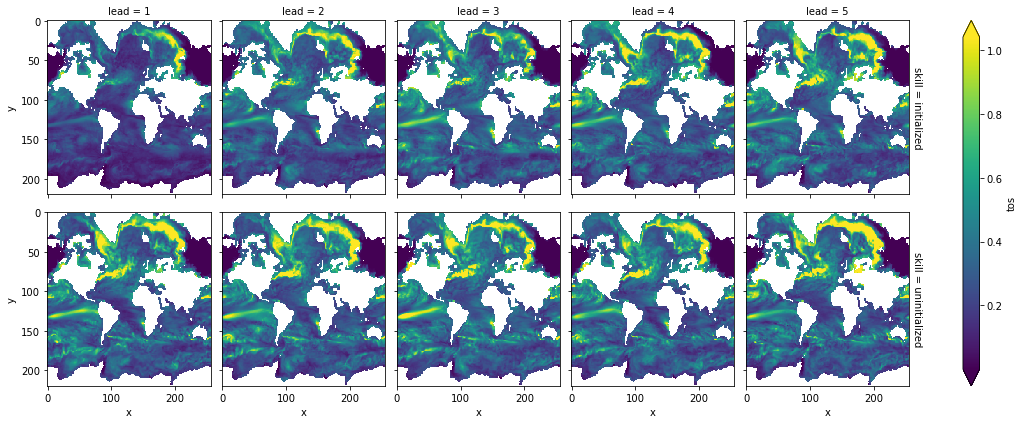

In [11]:
skill = pm.verify(metric='mae', comparison='m2e', dim=['init', 'member'], reference='uninitialized')
skill.tos.T.plot(col='lead', row='skill', yincrease=False, robust=True)

Text(0.5, 1.0, 'Predictable due to initialization for')

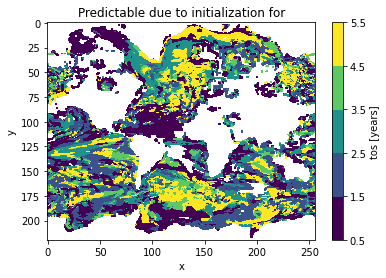

In [12]:
# initialized data has only five leads
ph = horizon(skill.sel(skill='initialized')<skill.sel(skill='uninitialized'))

ph.tos.T.plot(yincrease=False,levels=np.arange(0.5,5.51))
plt.title('Predictable due to initialization for')

## References

1. Bushuk, Mitchell, Rym Msadek, Michael Winton, Gabriel Vecchi, Xiaosong Yang, Anthony Rosati, and Rich Gudgel. “Regional Arctic Sea–Ice Prediction: Potential versus Operational Seasonal Forecast Skill.” Climate Dynamics, June 9, 2018. https://doi.org/10/gd7hfq.
1. Collins, Matthew, and Sinha Bablu. “Predictability of Decadal Variations in the Thermohaline Circulation and Climate.” Geophysical Research Letters 30, no. 6 (March 22, 2003). https://doi.org/10/cts3cr.
1. Goddard, Lisa, et al. "A verification framework for interannual-to-decadal predictions experiments." Climate Dynamics 40.1-2 (2013): 245-272.
1. Griffies, S. M., and K. Bryan. “A Predictability Study of Simulated North Atlantic Multidecadal Variability.” Climate Dynamics 13, no. 7–8 (August 1, 1997): 459–87. https://doi.org/10/ch4kc4.
1. Hawkins, Ed, Steffen Tietsche, Jonathan J. Day, Nathanael Melia, Keith Haines, and Sarah Keeley. “Aspects of Designing and Evaluating Seasonal-to-Interannual Arctic Sea-Ice Prediction Systems.” Quarterly Journal of the Royal Meteorological Society 142, no. 695 (January 1, 2016): 672–83. https://doi.org/10/gfb3pn.
1. Li, Hongmei, Tatiana Ilyina, Wolfgang A. Müller, and Frank Sienz. “Decadal Predictions of the North Atlantic CO2 Uptake.” Nature Communications 7 (March 30, 2016): 11076. https://doi.org/10/f8wkrs.
1. Pohlmann, Holger, Michael Botzet, Mojib Latif, Andreas Roesch, Martin Wild, and Peter Tschuck. “Estimating the Decadal Predictability of a Coupled AOGCM.” Journal of Climate 17, no. 22 (November 1, 2004): 4463–72. https://doi.org/10/d2qf62.